<a href="https://colab.research.google.com/github/emiliapo/HealthyAgeing/blob/Working/HealthyAgeingNotebook7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[69, 1]
[[79  1]
 [75  1]
 [65  0]
 [69  1]
 [80  1]]
[1 1 0 1 1]
[79 75 65 69 80]
Epoch 1/500
5/5 [==============================] - 2s 141ms/step - loss: 69.4130 - sex_out_loss: 0.7329 - age_out_loss: 68.3807 - sex_out_accuracy: 0.5078 - age_out_accuracy: 0.0000e+00 - val_loss: 38.6195 - val_sex_out_loss: 1.2461 - val_age_out_loss: 37.0852 - val_sex_out_accuracy: 0.5514 - val_age_out_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 38.61948, saving model to Age_sex_detection.h5
Epoch 2/500
5/5 [==============================] - 0s 55ms/step - loss: 25.2538 - sex_out_loss: 1.6805 - age_out_loss: 23.2874 - sex_out_accuracy: 0.5286 - age_out_accuracy: 0.0000e+00 - val_loss: 37.9157 - val_sex_out_loss: 0.7202 - val_age_out_loss: 36.9190 - val_sex_out_accuracy: 0.5234 - val_age_out_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 38.61948 to 37.91573, saving model to Age_sex_detection.h5
Epoch 3/500
5/5 [==============================] - 0s 55ms/step - loss: 20.92

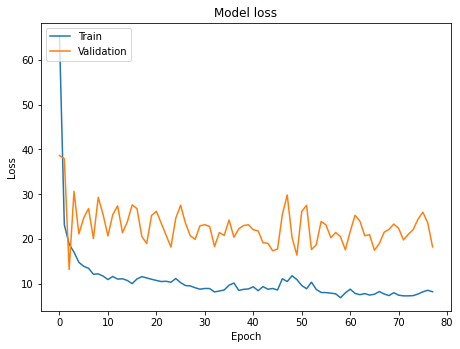

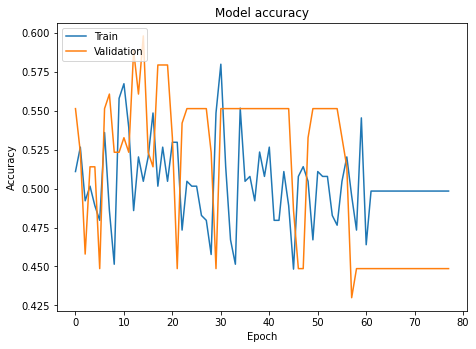

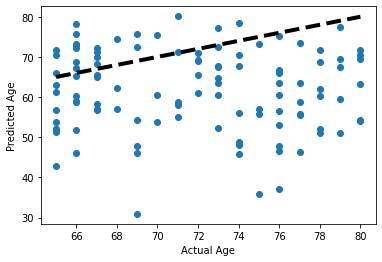

              precision    recall  f1-score   support

           0       0.45      0.92      0.60        48
           1       0.56      0.08      0.15        59

    accuracy                           0.46       107
   macro avg       0.50      0.50      0.37       107
weighted avg       0.51      0.46      0.35       107



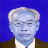

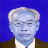

[array([[0.42923626]], dtype=float32), array([[65.32784]], dtype=float32)]
Index: 23
Predicted Age: 65
Predicted Sex: Male


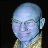

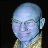

[array([[0.41573846]], dtype=float32), array([[53.326595]], dtype=float32)]
Index: 3
Predicted Age: 53
Predicted Sex: Male


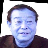

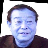

[array([[0.4994251]], dtype=float32), array([[79.664055]], dtype=float32)]
Index: 0
Predicted Age: 80
Predicted Sex: Male


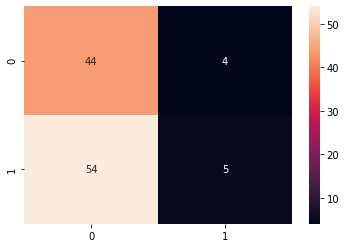

In [19]:
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
import seaborn as sns
from google.colab.patches import cv2_imshow

i = 0
last = []
labels = []
images = []
ageList = []
sexList = []

class Image:

    def image_processing(self, folder):
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                label = self.establishLabels(filename)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48, 48))
                images.append(img)
                sexList.append(label[1])
                ageList.append(label[0])

                labels.append(label)

        #self.showProcessedImage(23)

        # convert the labels and images to NumPy arrays

        images_f = np.array(images)
        sexList_f = np.array(sexList)
        ageList_f = np.array(ageList)
        labels_f = np.array(labels)

        print(labels[0])

        np.save(folder + 'image.npy', images_f)
        np.save(folder + 'gender.npy', sexList_f)
        np.save(folder + 'age.npy', ageList_f)

        #self.showSexDistribution(sexList_f)
        #self.showAgeDistribution(ageList_f)

        # normalise the images array by dividing it with 255

        images_f_2 = images_f / 255
        X_train, X_test, Y_train, Y_test = train_test_split(images_f_2, labels_f, test_size=0.25)
        print(Y_train[0:5])

        Y_train_2 = [Y_train[:, 1], Y_train[:, 0]]
        Y_test_2 = [Y_test[:, 1], Y_test[:, 0]]

        print(Y_train_2[0][0:5])

        print(Y_train_2[1][0:5])

        Model = self.model((48, 48, 3))
        # print(Model.summary())

        self.trainAndEvaluateModel(Model, X_train, X_test, Y_train, Y_test, Y_train_2, Y_test_2)
        self.test_image(23, images_f, images_f_2, Model)
        self.test_image(3, images_f, images_f_2, Model)
        self.test_image(0, images_f, images_f_2, Model)



    def establishLabels(self, filename):
        name = filename.split(".")[0]
        splitName = name.split("A")
        s = int(splitName[-1])
        a = int(splitName[-2])
        #output = {'sex': s, 'age': a}
        output = [a, s]

        return output

    def showProcessedImage(self, index):

        cv2.imshow("ProcessedImage", images[index])
        print(ageList[index])
        print(sexList[index])

        print("Press any key to exit...")
        cv2.waitKey(0) #waits for any key press

    def showSexDistribution(self, sexList_f):
        values, counts = np.unique(sexList_f, return_counts=True)
        #print(counts) #returns 207, 219

        plt.xlabel("Sex")
        plt.ylabel("Distribution")
        sex = ['Female', 'Male']
        plt.bar(sex, counts)
        plt.show()


    def showAgeDistribution(self, ageList_f):
        values, counts = np.unique(ageList_f, return_counts=True)
        #print(counts)

        plt.plot(values, counts)
        plt.xlabel('ages')
        plt.ylabel('distribution')
        plt.show()

    def Convolution(self, input_tensor, filters):
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(
            input_tensor)
        x = Dropout(0.1)(x)
        x = Activation('relu')(x)
        return x


    def model(self, input_shape):
        inputs = Input((input_shape))

        conv_1 = self.Convolution(inputs, 32)
        maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
        conv_2 = self.Convolution(maxp_1, 64)
        maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
        conv_3 = self.Convolution(maxp_2, 128)
        maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
        conv_4 = self.Convolution(maxp_3, 256)
        maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
        flatten = Flatten()(maxp_4)
        dense_1 = Dense(64, activation='relu')(flatten)
        dense_2 = Dense(64, activation='relu')(flatten)
        drop_1 = Dropout(0.2)(dense_1)
        drop_2 = Dropout(0.2)(dense_2)
        output_1 = Dense(1, activation="sigmoid", name='sex_out')(drop_1)
        output_2 = Dense(1, activation="relu", name='age_out')(drop_2)

        model = Model(inputs=[inputs], outputs=[output_1, output_2])
        model.compile(loss=["binary_crossentropy", "mae"], optimizer="Adam",
                      metrics=["accuracy"])
        return model

    def trainAndEvaluateModel(self, Model, X_train, X_test, Y_train,
                              Y_test, Y_train_2, Y_test_2):
        fle_s='Age_sex_detection.h5'
        checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
        Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
        callback_list=[checkpointer,Early_stop]

        History = Model.fit(X_train, Y_train_2,
                 batch_size=64,
                 validation_data=(X_test, Y_test_2),
                 epochs=500,
                 callbacks=[callback_list])
        
        print(Model.evaluate(X_test, Y_test_2))
        pred=Model.predict(X_test)

        print(pred[1])

        plt.plot(History.history['loss'])
        plt.plot(History.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                                wspace=0.35)
        plt.show()
        
        #For sex

        plt.plot(History.history['sex_out_accuracy'])
        plt.plot(History.history['val_sex_out_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                                wspace=0.35)
        plt.show()
        
        #for age

        fig, ax = plt.subplots()
        ax.scatter(Y_test_2[1], pred[1])
        ax.plot([Y_test_2[1].min(),Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
        ax.set_xlabel('Actual Age')
        ax.set_ylabel('Predicted Age')

        plt.show()

        #for sex
        j = 0
        Pred_l=[]
        while(j<len(pred[0])):
          Pred_l.append(int(np.round(pred[0][j])))
          j+=1

        report=classification_report(Y_test_2[0], Pred_l)
        print(report)

        results = confusion_matrix(Y_test_2[0], Pred_l)
        sns.heatmap(results, annot=True)

    def test_image(self, ind, images_f, images_f_2, Model):
      cv2_imshow(images_f[ind])
      cv2_imshow(images[ind])
      image_test=images_f_2[ind]
      pred_1=Model.predict(np.array([image_test]))
      print(pred_1)
      sex_f=['Male','Female']
      age=int(np.round(pred_1[1][0]))
      sex=int(np.round(pred_1[0][0]))
      print("Index: "+ str(ind))
      print("Predicted Age: "+ str(age))
      print("Predicted Sex: "+ sex_f[sex])
        
folder = "/content/Data/Eastern_Elderly_Faces"
Image().image_processing(folder)